## Makemore Part 5 

Building makemore Part 5: Building a WaveNet 
https://www.youtube.com/watch?v=t3YJ5hKiMQ0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=6

In [31]:
# Run using python 3.8.5 kernel 
import torch 
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
%matplotlib inline

In [32]:
words = open('names.txt', 'r').read().splitlines() 
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [33]:
# build vocab of chars and mapping to / from integers
chars = sorted(list(set(''.join(words)))) # get all distinct chars, sorted
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [34]:
import random 
random.seed(42) 
random.shuffle(words) 

In [35]:
# build dataset
block_size = 3 

def build_dataset(words): 

    X, Y = [], [] 

    for w in words: 
        context = [0] * block_size 
        for ch in w + '.': 
            ix = stoi[ch]  
            X.append(context) 
            Y.append(ix) 
            context = context[1:] + [ix] 

    X = torch.tensor(X) 
    Y = torch.tensor(Y) 
    print(X.shape, Y.shape)
    return X, Y 

import random 
random.seed(42) 
random.shuffle(words) # mix up the words 
n1 = int(0.8*len(words)) # 80% of words 
n2 = int(0.9*len(words)) # 90% of words 

Xtr, Ytr = build_dataset(words[:n1]) 
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [36]:
for x,y in zip(Xtr[:20], Ytr[:20]): 
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

... --> e
..e --> b
.eb --> r
ebr --> i
bri --> m
rim --> a
ima --> .
... --> h
..h --> i
.hi --> l
hil --> t
ilt --> o
lto --> n
ton --> .
... --> j
..j --> h
.jh --> e
jhe --> n
hen --> e
ene --> .


In [118]:
# very similar to pytorch linear layer 
# this from part 3 
class Linear: 

    def __init__(self, fan_in, fan_out, bias=True): 
        # randn is unit Gaussian at first 
        # then we use Kanming by default 
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None 

    def __call__(self, x): 
        self.out = x @ self.weight 
        if self.bias is not None: 
            self.out += self.bias 
        return self.out 
    
    def parameters(self): 
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d: 

    def __init__(self, dim, eps=1e-5, momentum=0.1): 
        self.eps = eps  # for avoiding division by 0 
        self.momentum = momentum 
        self.training = True # bc we behave differently for train and inference
        # parameters (trained with backprop) 
        self.gamma = torch.ones(dim) # like gain above 
        self.beta = torch.zeros(dim) 
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim) 
        self.running_var = torch.ones(dim) 

    def __call__(self, x): 
        # calculate the forward pass 
        if self.training: 
            # this if/elif was added to accommodate our wavenet! 
            if x.ndim == 2: 
                dim = 0 
            elif x.ndim == 3: 
                dim = (0,1) # this is actually diff from pytorch, which expects (0,2)
            xmean = x.mean(dim, keepdim=True) # batch mean 
            xvar = x.var(dim, keepdim=True) # batch variance 
        else: 
            xmean = self.running_mean 
            xvar = self.running_var 
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta # making it easier to maintain and plot 

        # update the buffers
        if self.training: 
            with torch.no_grad(): 
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar 
        return self.out 
    
    def parameters(self): 
        return [self.gamma, self.beta]

class Tanh: 
    def __call__(self, x): 
        self.out = torch.tanh(x) 
        return self.out 
    def parameters(self): 
        return []
    
# NEW CLASSES -- so we can have our forward pass be strictly layer applications! 
# Embedding replaces the indexing into C 
# Flattening concatenates our 3 vectors representing chars into one vector 
# Turns out both of these exist in pytorch, same names! (+ more params)
class Embedding: 
    def __init__(self, num_embeddings, embedding_dim): 
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX): 
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self): 
        return [self.weight]
    
class FlattenConsecutive: # we renamed this and modified it for WaveNet  
    def __init__(self, n): 
        self.n = n 

    def __call__(self, x): 
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1: # if we have a spurious dimension: 
            x = x.squeeze(1) # get rid of dimension 1. (by default will eliminate any 1 dim) 
        self.out = x
        return self.out 
    def parameters(self): 
        return []
    
        
    
class Sequential: 
    def __init__(self, layers): 
        self.layers = layers
    
    def __call__(self, x): 
        for layer in self.layers: 
            x = layer(x) 
        self.out = x 
        return self.out 
    
    def parameters(self): 
        return [p for layer in self.layers for p in layer.parameters()]

In [49]:
torch.manual_seed(42)

In [ ]:
# Initializing a network 

n_embd = 10 # dimensionality of character embedding vectors 
n_hidden = 200 # number of neurons in hidden layer 

model = Sequential([
    Embedding(vocab_size, n_embd), 
    FlattenConsecutive(), 
    Linear(n_embd * block_size, n_hidden, bias=False), 
    BatchNorm1d(n_hidden),
    Tanh(), 
    Linear(n_hidden, vocab_size),
]) 

with torch.no_grad(): 
    # last layer: make less confident 
    model.layers[-1].weight *= 0.1 # he doesn't fix this but would be easy 

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters: 
    p.requires_grad = True 


12097


In [68]:
# same optimization as last time 
max_steps = 200000
batch_size = 32 
lossi = []

for i in range(max_steps): 
    # minibatch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass 
    logits = model(Xb) 
    loss = F.cross_entropy(logits, Yb) # loss function 

    # backward pass 
    for p in parameters: 
        p.grad = None 
    loss.backward() 

    # update 
    lr = 0.1 if i < 100000 else 0.01 # learning rate decay 
    for p in parameters: 
        p.data += -lr * p.grad 

    # track stats 
    if i % 10000 == 0: 
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2454
  10000/ 200000: 2.5250
  20000/ 200000: 2.2341
  30000/ 200000: 2.0641
  40000/ 200000: 2.1465
  50000/ 200000: 2.2138
  60000/ 200000: 2.5270
  70000/ 200000: 2.0341
  80000/ 200000: 2.1263
  90000/ 200000: 1.6464
 100000/ 200000: 2.5963
 110000/ 200000: 2.3270
 120000/ 200000: 1.8420
 130000/ 200000: 1.8104
 140000/ 200000: 2.0415
 150000/ 200000: 2.2511
 160000/ 200000: 2.0037
 170000/ 200000: 2.2771
 180000/ 200000: 2.0454
 190000/ 200000: 2.0538


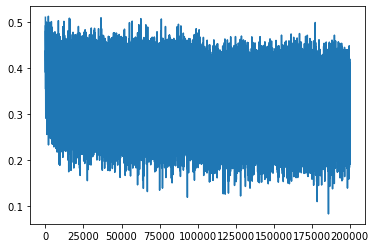

In [69]:
# Andrej said the thickness of this plot is like daggers in his eyes... 
# batches too small = too much up and down of loss 
plt.plot(lossi)

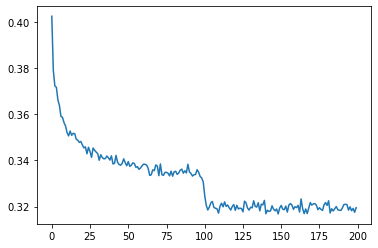

In [70]:
# look at the avg loss over time in groups of 1000 batches 
# looks like learning rate decrease helped us lock down something lower! 
# altho why is the mean 0.32 if we have 0.2? 
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1)) 

In [71]:
for layer in model.layers: 
    layer.training = False 

In [72]:
@torch.no_grad() # this decorator disables gradient tracking 
def split_loss(split): 
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    logits = model(x) 
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0661983489990234
val 2.1100142002105713


In [73]:
for _ in range(20): 
    out = []
    context = [0] * block_size 
    while True: 
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item() 
        context = context[1:] + [ix]
        out.append(ix) 
        if ix == 0: 
            break 

    print(''.join(itos[i] for i in out))

khaiz.
smraneedeston.
alabardow.
mel.
man.
kinity.
sheem.
milanes.
lylee.
rose.
stas.
saynci.
stynicah.
hat.
yassia.
keh.
artyn.
atseesleyannon.
dolionariya.
mellam.


## Ok building something Wavenet inspired! 
Fuse groups of 2 chars into bigrams, then those groups into groups of 4, etc 
Progressively incorporating more info 

#### a: naive just 8 char context instead of 3 

In [77]:
# increasing block size 
block_size = 8

random.seed(42) 
random.shuffle(words) # mix up the words 
n1 = int(0.8*len(words)) # 80% of words 
n2 = int(0.9*len(words)) # 90% of words 

Xtr, Ytr = build_dataset(words[:n1]) 
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182441, 8]) torch.Size([182441])
torch.Size([22902, 8]) torch.Size([22902])
torch.Size([22803, 8]) torch.Size([22803])


In [78]:
for x,y in zip(Xtr[:20], Ytr[:20]): 
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> e
.......e --> l
......el --> i
.....eli --> a
....elia --> n
...elian --> y
..eliany --> s
.elianys --> .
........ --> t
.......t --> r
......tr --> o
.....tro --> y
....troy --> .
........ --> m
.......m --> a
......ma --> r
.....mar --> k
....mark --> u
...marku --> s
..markus --> .


In [79]:
torch.manual_seed(42)

In [119]:
# Initializing a network 

n_embd = 10 # dimensionality of character embedding vectors 
n_hidden = 200 # number of neurons in hidden layer 

model = Sequential([
    Embedding(vocab_size, n_embd), 
    FlattenConsecutive(block_size), 
    Linear(n_embd * block_size, n_hidden, bias=False), 
    BatchNorm1d(n_hidden),
    Tanh(), 
    Linear(n_hidden, vocab_size),
]) 

with torch.no_grad(): 
    # last layer: make less confident 
    model.layers[-1].weight *= 0.1 # he doesn't fix this but would be easy 

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters: 
    p.requires_grad = True 


22097


In [122]:
# same optimization as last time 
max_steps = 200000
batch_size = 32 
lossi = []

for i in range(max_steps): 
    # minibatch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass 
    logits = model(Xb) 
    loss = F.cross_entropy(logits, Yb) # loss function 

    # backward pass 
    for p in parameters: 
        p.grad = None 
    loss.backward() 

    # update 
    lr = 0.1 if i < 100000 else 0.01 # learning rate decay 
    for p in parameters: 
        p.data += -lr * p.grad 

    # track stats 
    if i % 10000 == 0: 
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 1.6403
  10000/ 200000: 2.0850
  20000/ 200000: 2.3254
  30000/ 200000: 1.8707
  40000/ 200000: 2.0901
  50000/ 200000: 2.0415
  60000/ 200000: 2.3591
  70000/ 200000: 1.9005
  80000/ 200000: 2.0436
  90000/ 200000: 2.2018
 100000/ 200000: 1.9588
 110000/ 200000: 1.8213
 120000/ 200000: 1.7877
 130000/ 200000: 1.8070
 140000/ 200000: 1.8533
 150000/ 200000: 2.3163
 160000/ 200000: 1.9926
 170000/ 200000: 1.7721
 180000/ 200000: 1.9548
 190000/ 200000: 1.5186


In [ ]:
# definitely improves our loss! 
@torch.no_grad() # this decorator disables gradient tracking 
def split_loss(split): 
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    logits = model(x) 
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9277074337005615
val 2.0280654430389404


### b actually the hierarchical model 

just checking out our data at first 

In [83]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb) 
print(Xb.shape) 
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  2, 18,  9, 20, 20,  5, 14],
        [ 0,  0,  0,  0,  0,  0, 10,  1],
        [ 0,  0,  0,  0,  0,  7,  9,  1]])

In [84]:
model.layers[0].out.shape

torch.Size([4, 8, 10])

In [85]:
model.layers[1].out.shape

torch.Size([4, 80])

In [ ]:
model.layers[2].out.shape
# this is like 4x80 matrix times 80x200 matrix plus a 200dim bias 

torch.Size([4, 200])

He notes that pytorch matrix multiplier can operate on more than 2 dimensions. 
E.g. it doesn't need to be (4x80) times (80x200). It could be (4x5x80) times (80x200) 
Pytorch treats it sort of like another dimension of batches and just multiplies
along the last dimension. 
Helpful given that we want to process our characters in parallel in batches: 
(1 2) (3 4) (5 6) (7 8)

Instead of 4x80 times 80x200, we want: 
(4x4x20) => 4 examples, 4 groups of chars, each group has 2 chars or 20 dimensional embedding 
(80x200) linear layer should only expect 20d vector coming in 


In [88]:
e = torch.randn(4, 8, 10) # want this to be 4x4x20 
e[:, ::2, :] # the ::2 says just even characters 
e[:, 1::2, :] # this is all odd characters 

# let's concatenate these along the second dimension 
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
explicit.shape

torch.Size([4, 4, 20])

In [ ]:
# wow.. or you can just use view! so handy 
# and it gives you the same result 
(e.view(4, 4, 20) == explicit).all()

tensor(True)

In [123]:
# Initializing a network 

n_embd = 10 # dimensionality of character embedding vectors 
n_hidden = 68 # reducing this so we have same # of params roughly 

model = Sequential([
    Embedding(vocab_size, n_embd), 

    # grouping chars in groups of 2 
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    # then 4 
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    # then 8
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    Linear(n_hidden, vocab_size),
]) 

with torch.no_grad(): 
    # last layer: make less confident 
    model.layers[-1].weight *= 0.1 # he doesn't fix this but would be easy 

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters: 
    p.requires_grad = True 


22397


In [109]:
# toy example again 
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb) 
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  3],
        [ 0,  0,  0,  0,  0, 19,  1, 13],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0, 10,  1, 26, 13]])

In [110]:
for layer in model.layers: 
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsecutive : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsecutive : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)


In [124]:
# same optimization as last time 
max_steps = 200000
batch_size = 32 
lossi = []

for i in range(max_steps): 
    # minibatch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass 
    logits = model(Xb) 
    loss = F.cross_entropy(logits, Yb) # loss function 

    # backward pass 
    for p in parameters: 
        p.grad = None 
    loss.backward() 

    # update 
    lr = 0.1 if i < 100000 else 0.01 # learning rate decay 
    for p in parameters: 
        p.data += -lr * p.grad 

    # track stats 
    if i % 10000 == 0: 
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.2784
  10000/ 200000: 2.8707
  20000/ 200000: 1.7554
  30000/ 200000: 2.2420
  40000/ 200000: 2.1277
  50000/ 200000: 2.0366
  60000/ 200000: 1.9148
  70000/ 200000: 1.5717
  80000/ 200000: 2.5683
  90000/ 200000: 2.0915
 100000/ 200000: 1.9880
 110000/ 200000: 2.1625
 120000/ 200000: 2.0720
 130000/ 200000: 1.9207
 140000/ 200000: 1.5053
 150000/ 200000: 1.9025
 160000/ 200000: 2.1609
 170000/ 200000: 1.8950
 180000/ 200000: 1.9935
 190000/ 200000: 1.9744


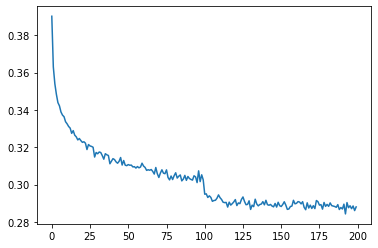

In [125]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1)) 

In [126]:
split_loss('train')
split_loss('val')

train 1.9222395420074463
val 2.0189208984375


Very similar result. We could do more optimization -- but also need to take a 
closer look at Batchnorm -- it's running through right now, but maybe not 
correctly. We didn't design it with this use case in mind. 

In [ ]:
e = torch.randn(32, 4, 68) 

# rn means are only taken over the 32 numbers in the first dimension 
emean = e.mean(0, keepdim=True) # 1, 4, 68 
evar = e.var(0, keepdim=True) # 1, 4, 68 

print(model.layers[3].running_mean.shape) 

# We want this to run over 68 channels, not 4x68 
# We want to treat the 4 as a batch dimension, just like the 0th dimension 
# Seems like we want the same avgs for all pairs of 2 chars, for example 

# What we should do instead is: 
emean = e.mean((0,1), keepdim=True) # 1, 4, 68 
emean.shape

# this is now fixed in our implementation of batchnorm 

torch.Size([1, 4, 68])


torch.Size([1, 1, 68])

### trying more neurons in our wavenet 

In [127]:
# Initializing a network 

n_embd = 10 # dimensionality of character embedding vectors 
n_hidden = 128 # reducing this so we have same # of params roughly 

model = Sequential([
    Embedding(vocab_size, n_embd), 

    # grouping chars in groups of 2 
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    # then 4 
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    # then 8
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    Linear(n_hidden, vocab_size),
]) 

with torch.no_grad(): 
    # last layer: make less confident 
    model.layers[-1].weight *= 0.1 # he doesn't fix this but would be easy 

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters: 
    p.requires_grad = True 


72617


In [128]:
# same optimization as last time 
max_steps = 200000
batch_size = 32 
lossi = []

for i in range(max_steps): 
    # minibatch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass 
    logits = model(Xb) 
    loss = F.cross_entropy(logits, Yb) # loss function 

    # backward pass 
    for p in parameters: 
        p.grad = None 
    loss.backward() 

    # update 
    lr = 0.1 if i < 100000 else 0.01 # learning rate decay 
    for p in parameters: 
        p.data += -lr * p.grad 

    # track stats 
    if i % 10000 == 0: 
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.3289
  10000/ 200000: 2.0724
  20000/ 200000: 2.4443
  30000/ 200000: 1.9203
  40000/ 200000: 2.0261
  50000/ 200000: 2.0673
  60000/ 200000: 2.2431
  70000/ 200000: 2.4649
  80000/ 200000: 2.6019
  90000/ 200000: 1.3830
 100000/ 200000: 1.9304
 110000/ 200000: 2.0226
 120000/ 200000: 2.1434
 130000/ 200000: 1.8768
 140000/ 200000: 1.5387
 150000/ 200000: 2.0156
 160000/ 200000: 2.2109
 170000/ 200000: 1.7822
 180000/ 200000: 1.6991
 190000/ 200000: 2.2018


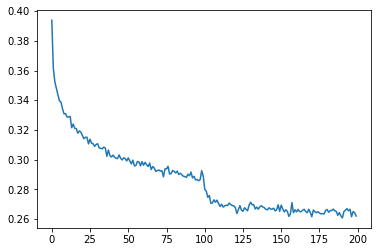

In [129]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1)) 

In [130]:
split_loss('train')
split_loss('val')

train 1.8122029304504395
val 1.9938666820526123
